In [1]:
# Naive Streaming LSTM Autoencoder with Batch Prediction

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from collections import deque

# Configuration
DATA_DIR = "generated_datasets"
RESULTS_DIR = "results_streaming"
os.makedirs(RESULTS_DIR, exist_ok=True)

WINDOW_SIZE = 30
LATENT_DIM = 32
EPOCHS = 5
BATCH_SIZE = 32
CONTAMINATION = 0.05
INITIAL_TRAIN_SIZE = 2000

In [2]:
# Build LSTM Autoencoder
def build_model(window_size):
    input_layer = Input(shape=(window_size, 1))
    encoded = LSTM(LATENT_DIM, activation='relu')(input_layer)
    decoded = RepeatVector(window_size)(encoded)
    decoded = LSTM(LATENT_DIM, activation='relu', return_sequences=True)(decoded)
    output = TimeDistributed(Dense(1))(decoded)
    return Model(inputs=input_layer, outputs=output)

# Prepare training sequences
def create_sequences(data, window_size):
    return np.array([data[i:i + window_size] for i in range(len(data) - window_size)])


Processing normality_1_daphnet.npy
Precision: 0.352, Recall: 0.155, F1: 0.215, AUC: 0.706, Time: 99.33s


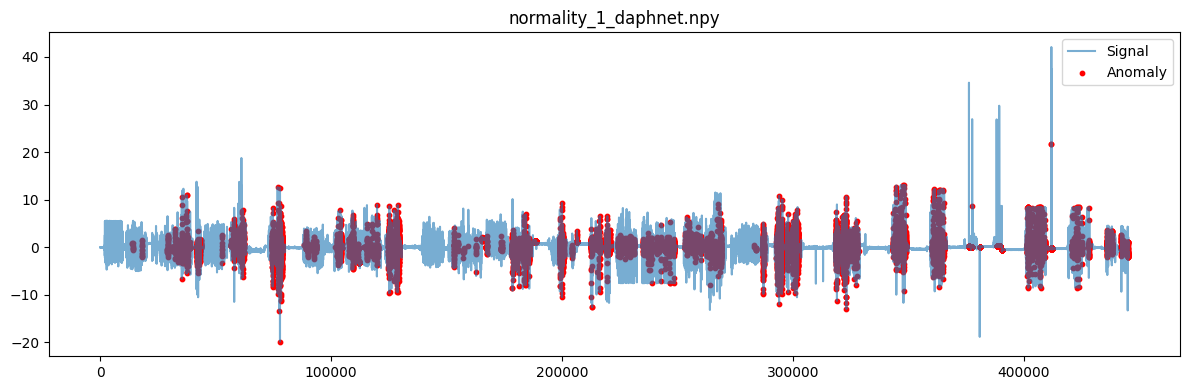


Processing normality_1_genesis.npy
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.357, Time: 14.03s


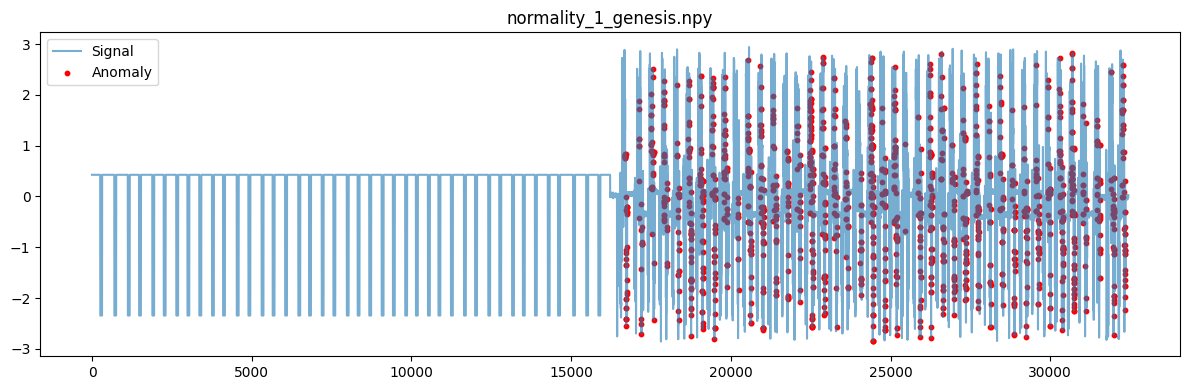


Processing normality_1_nasa-msl.npy
Precision: 0.223, Recall: 0.181, F1: 0.200, AUC: 0.718, Time: 16.71s


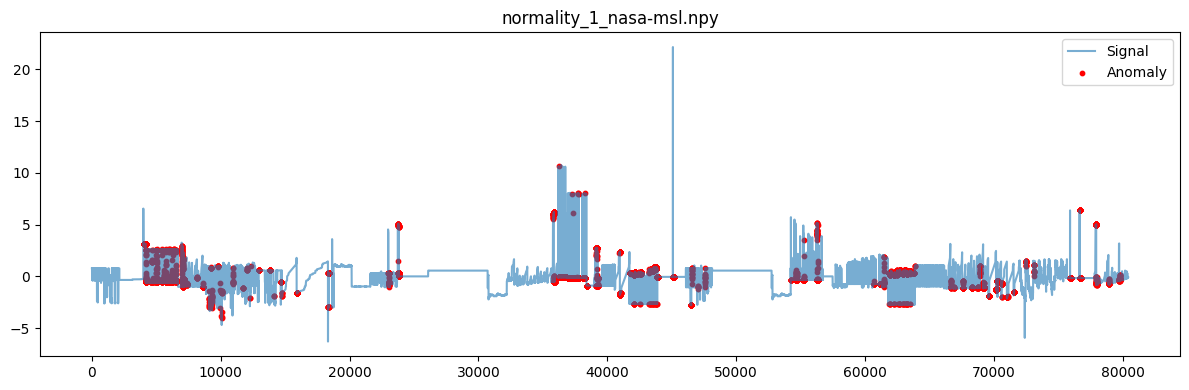


Processing normality_2_1_daphnet_genesis.npy
Precision: 0.389, Recall: 0.183, F1: 0.249, AUC: 0.741, Time: 60.85s


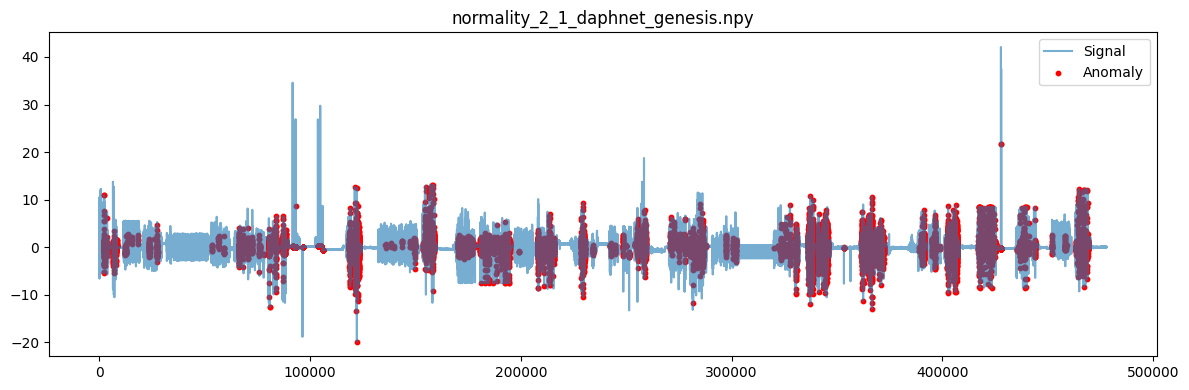


Processing normality_2_2_daphnet_nasa-msl.npy
Precision: 0.383, Recall: 0.181, F1: 0.246, AUC: 0.739, Time: 67.49s


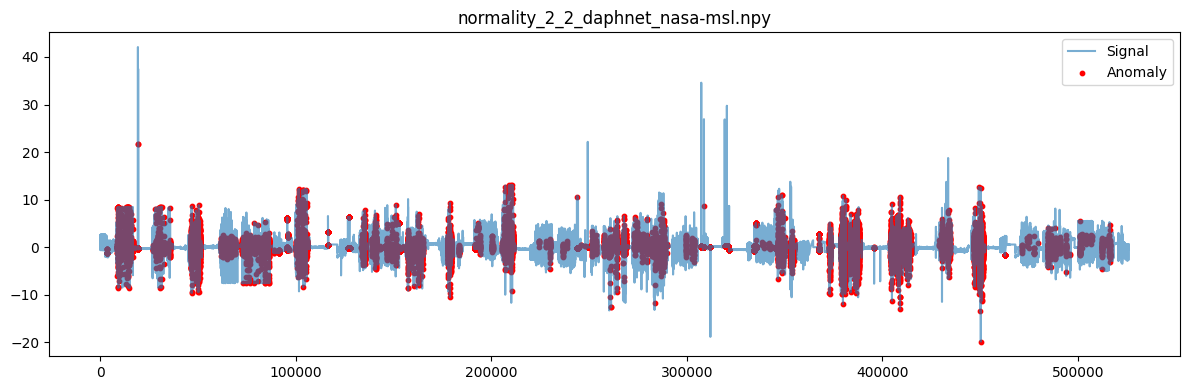


Processing normality_2_3_genesis_nasa-msl.npy
Precision: 0.126, Recall: 0.141, F1: 0.133, AUC: 0.663, Time: 22.25s


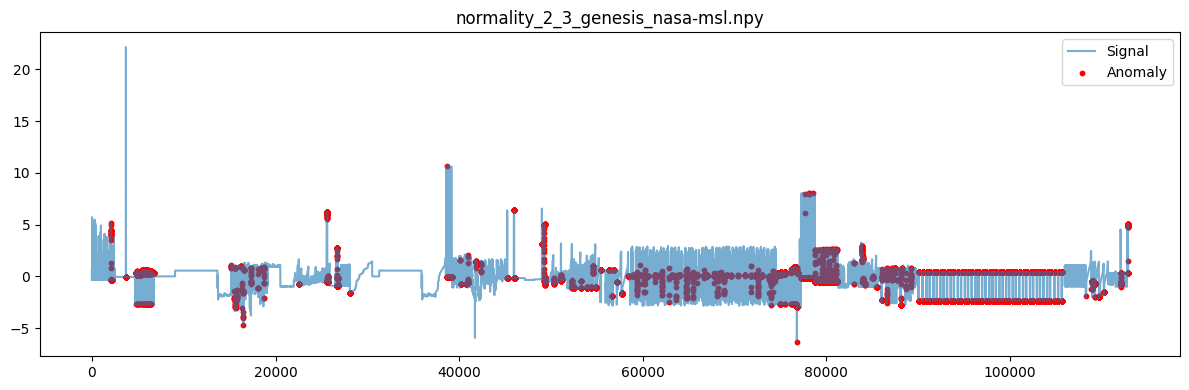


Processing normality_3_1_daphnet_genesis_nasa-msl.npy
Precision: 0.376, Recall: 0.188, F1: 0.251, AUC: 0.748, Time: 80.05s


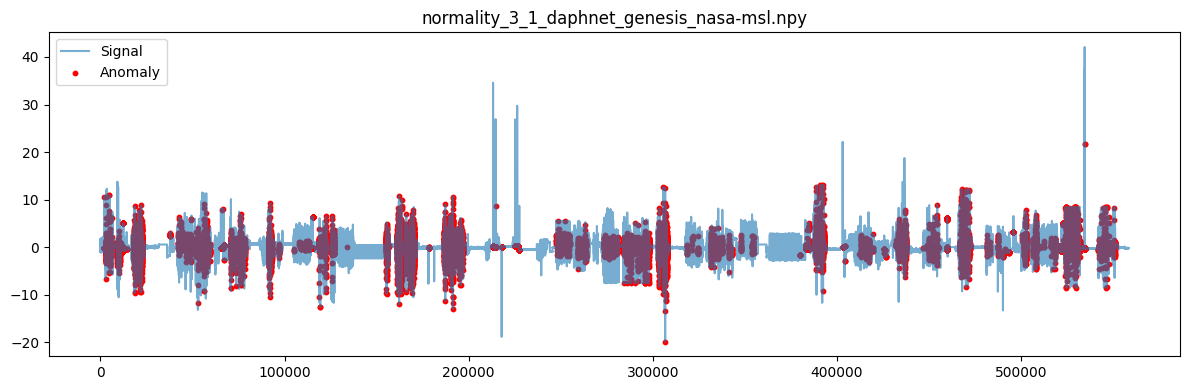


Processing normality_3_2_genesis_nasa-msl_daphnet.npy
Precision: 0.374, Recall: 0.188, F1: 0.250, AUC: 0.745, Time: 83.58s


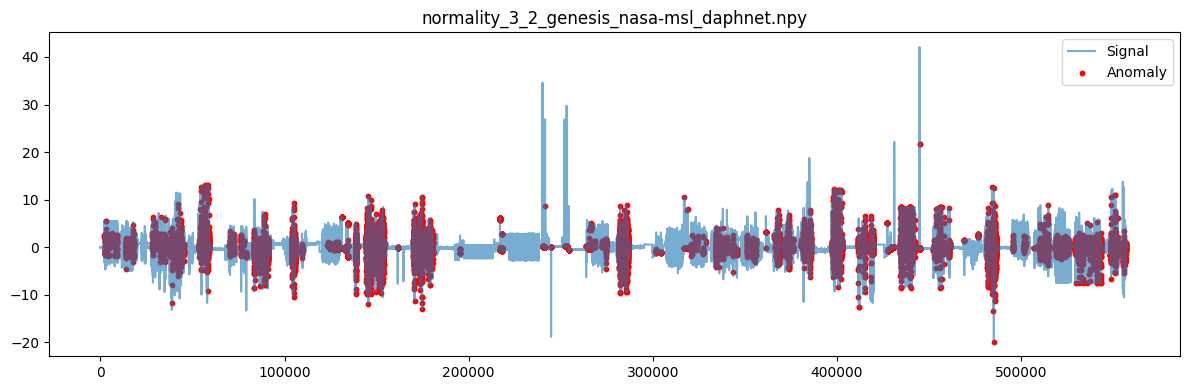


Processing normality_3_3_nasa-msl_daphnet_genesis.npy
Precision: 0.378, Recall: 0.190, F1: 0.252, AUC: 0.758, Time: 98.64s


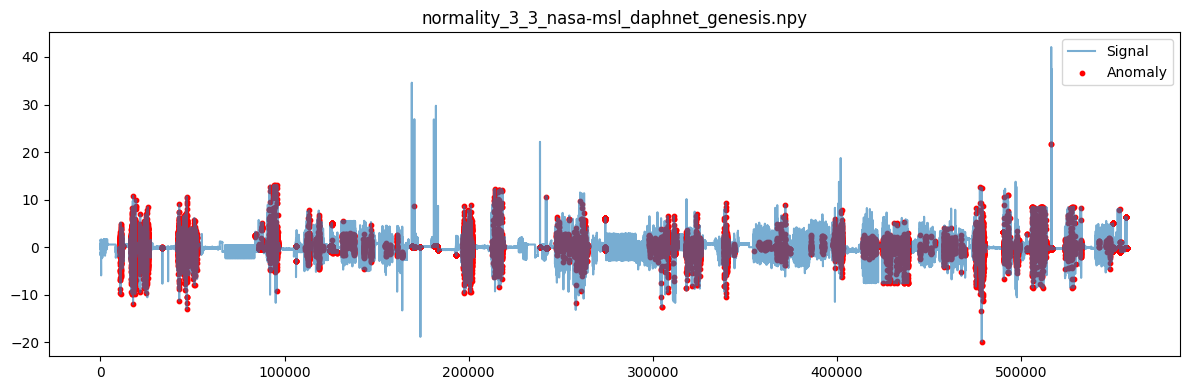

In [3]:
# Streaming anomaly detection with batch prediction
summary = []

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".npy") or "_labels" in fname or "_boundaries" in fname:
        continue

    print(f"\nProcessing {fname}")
    ts_path = os.path.join(DATA_DIR, fname)
    label_path = ts_path.replace(".npy", "_labels.npy")

    if not os.path.exists(label_path):
        print(f"Skipping {fname}, missing labels.")
        continue

    ts = np.load(ts_path)
    labels = np.load(label_path)

    # Normalize the data
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts.reshape(-1, 1)).flatten()

    if len(ts_scaled) < INITIAL_TRAIN_SIZE + WINDOW_SIZE:
        print(f"Skipping {fname}, too short for streaming.")
        continue

    # Initial unsupervised training
    start_time = time.time()
    train_seq = create_sequences(ts_scaled[:INITIAL_TRAIN_SIZE], WINDOW_SIZE)
    train_seq = train_seq.reshape((-1, WINDOW_SIZE, 1))

    model = build_model(WINDOW_SIZE)
    model.compile(optimizer='adam', loss='mse')
    model.fit(train_seq, train_seq, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    # Streaming: batch window preparation
    stream_windows = []
    window = deque(ts_scaled[INITIAL_TRAIN_SIZE - WINDOW_SIZE:INITIAL_TRAIN_SIZE], maxlen=WINDOW_SIZE)

    for t in range(INITIAL_TRAIN_SIZE, len(ts_scaled)):
        window.append(ts_scaled[t])
        stream_windows.append(np.array(window))

    X_stream = np.array(stream_windows).reshape((-1, WINDOW_SIZE, 1))
    X_pred = model.predict(X_stream, verbose=0, batch_size=128)
    errors = np.mean((X_stream - X_pred) ** 2, axis=(1, 2))

    # Pad beginning with zeros
    scores = [0.0] * (INITIAL_TRAIN_SIZE + WINDOW_SIZE) + list(errors)
    scores = np.array(scores[:len(ts)])

    # Threshold and predictions
    threshold = np.percentile(scores, 100 * (1 - CONTAMINATION))
    preds = (scores > threshold).astype(int)
    y_true = labels[:len(preds)]

    # Metrics
    p = precision_score(y_true, preds, zero_division=0)
    r = recall_score(y_true, preds, zero_division=0)
    f = f1_score(y_true, preds, zero_division=0)
    a = roc_auc_score(y_true, scores) if len(set(y_true)) > 1 else 0.0
    elapsed = round(time.time() - start_time, 2)

    print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, AUC: {a:.3f}, Time: {elapsed}s")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(ts, label="Signal", alpha=0.6)
    anomaly_idxs = np.where(preds == 1)[0]
    plt.scatter(anomaly_idxs, ts[anomaly_idxs], color='red', s=10, label="Anomaly")
    plt.title(fname)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, fname.replace(".npy", ".png")))
    plt.show()
    plt.close()

    # Save summary
    summary.append(dict(dataset=fname, length=len(ts), precision=round(p, 3),
                        recall=round(r, 3), f1=round(f, 3), auc=round(a, 3), time=elapsed))

In [4]:
# Save results
if summary:
    df = pd.DataFrame(summary).set_index("dataset")
    display(df)
    df.to_csv(os.path.join(RESULTS_DIR, "lstm_streaming_v1.csv"))
else:
    print("No datasets were successfully processed.")

,length,precision,recall,f1,auc,time
dataset,,,,,,
normality_1_daphnet.npy,445440,0.352,0.155,0.215,0.706,99.33
normality_1_genesis.npy,32440,0.000,0.000,0.000,0.357,14.03
normality_1_nasa-msl.npy,80427,0.223,0.181,0.200,0.718,16.71
normality_2_1_daphnet_genesis.npy,477880,0.389,0.183,0.249,0.741,60.85
normality_2_2_daphnet_nasa-msl.npy,525867,0.383,0.181,0.246,0.739,67.49
normality_2_3_genesis_nasa-msl.npy,112867,0.126,0.141,0.133,0.663,22.25
normality_3_1_daphnet_genesis_nasa-msl.npy,558307,0.376,0.188,0.251,0.748,80.05
normality_3_2_genesis_nasa-msl_daphnet.npy,558307,0.374,0.188,0.250,0.745,83.58
normality_3_3_nasa-msl_daphnet_genesis.npy,558307,0.378,0.190,0.252,0.758,98.64
